In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd

In [2]:
df = pd.read_csv('clustering_data.csv')

In [3]:
df.isna().mean()*100

Trip ID                      0.0
Trip Seconds                 0.0
Trip Miles                   0.0
Pickup Census Tract          0.0
Fare                         0.0
Tips                         0.0
Tolls                        0.0
Extras                       0.0
Trip Total                   0.0
Payment Type                 0.0
Company                      0.0
Pickup Centroid Latitude     0.0
Pickup Centroid Longitude    0.0
bank                         0.0
bar                          0.0
biergarten                   0.0
cafe                         0.0
casino                       0.0
cinema                       0.0
college                      0.0
fast_food                    0.0
hospital                     0.0
ice_cream                    0.0
kindergarten                 0.0
library                      0.0
nightclub                    0.0
pub                          0.0
restaurant                   0.0
school                       0.0
taxi                         0.0
university

# 1. Preprocessing

In [4]:
payment_type = pd.get_dummies(df['Payment Type'], drop_first=True)
df = pd.concat([df, payment_type], axis=1) 

company = pd.get_dummies(df['Company'], drop_first=True)
df = pd.concat([df, company], axis=1)

time_of_day = pd.get_dummies(df['time_of_day'], drop_first=True)
df = pd.concat([df, time_of_day], axis=1)
df.drop(['Trip ID','Pickup Census Tract','Pickup Centroid Latitude','Pickup Centroid Longitude',
         'Payment Type','Company','time_of_day'], axis=1, inplace=True)

In [5]:
#Remove highly correlated variables
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df.drop(columns=to_drop, inplace=True)

In [6]:
#Normalize
numerical_features = df.select_dtypes(include=['float64', 'int64']) 
#scaler = StandardScaler()
scaler = MinMaxScaler()
df[numerical_features.columns] = scaler.fit_transform(numerical_features)


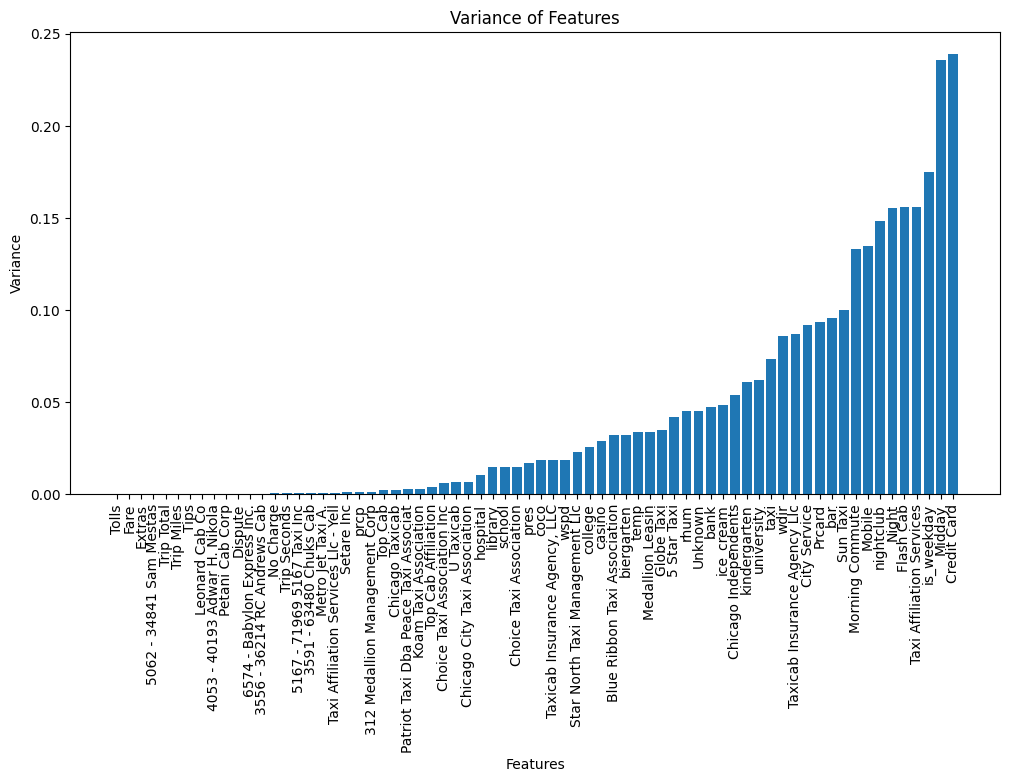

In [7]:
variances = df.var().sort_values()
plt.figure(figsize=(12, 6))
plt.bar(list(variances.index), variances)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance of Features')
plt.xticks(rotation=90)
plt.savefig('variance_feature.png')
plt.show()

In [8]:
### Remove low variance features (Unimportant)
selector = VarianceThreshold(threshold=0.01)
selector.fit_transform(df)
df = df.loc[:, selector.get_support()]
scaled_df = df.copy() ##

# 2. Clustering

## a. Decide number of centers

Because the large amount of data, we will do PCA to shorten the time.
We keep 95% of variance to avoid missing crucial information.

With PCA, we can also avoid the noise from data

In [9]:
pca = PCA(n_components=0.95) #keep 95% variance
df = pca.fit_transform(df)

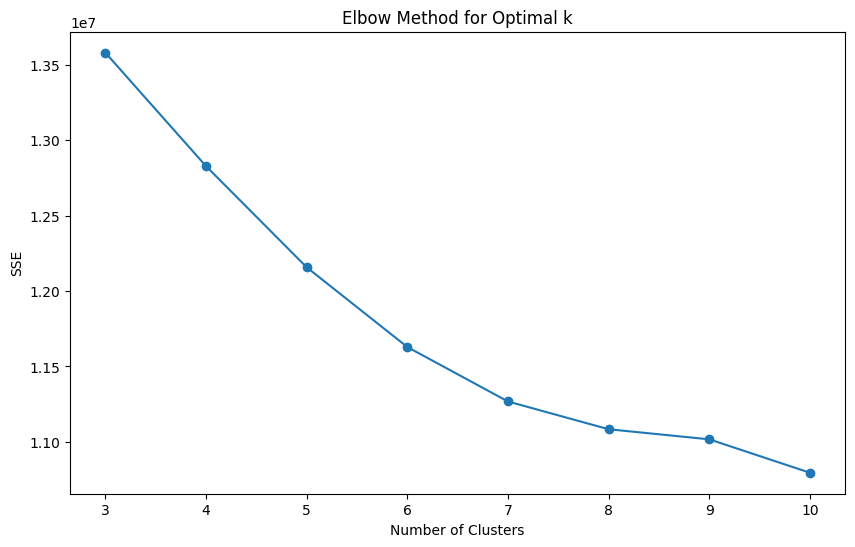

In [10]:
sse = []
for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=108)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.savefig('SSE_images.png')
plt.show()

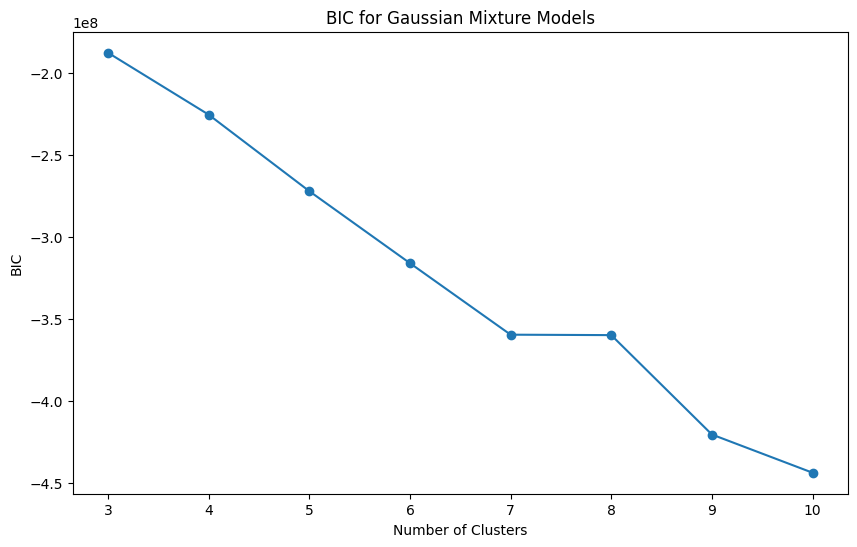

In [11]:
bic = []
n_components_range = range(3, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=108)
    gmm.fit(df)
    bic.append(gmm.bic(df))

# Plot BIC
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC for Gaussian Mixture Models')
plt.savefig('BIC_images.png')
plt.show()

- Elbow Method (SSE): the decrease in SSE becomes less dramatically after 7 clusters.
- BIC: Quite similar to SSE, BIC slightly increases from cluster 7 to 8 and slows down after that.

Therefore, having 7 clusters is reasonable.

## b. Cluster data

In [12]:
# Soft Clustering: Gaussian Mixture Model

gmm = GaussianMixture(n_components=7, covariance_type='full',random_state=108)
gmm_labels = gmm.fit_predict(df)

In [13]:
# Hard Clustering: K-Means

kmeans = KMeans(n_clusters=7, random_state=108)
kmeans_labels = kmeans.fit_predict(df)

# 3. Visualization

## a. Parallel coordinates 

### GMM

In [14]:
scaled_df['GMM_Cluster'] = gmm_labels
scaled_df['GMM_Cluster'] = scaled_df['GMM_Cluster'].astype('category')
scaled_gmm_cluster_means = scaled_df.groupby('GMM_Cluster').mean()
scaled_gmm_cluster_means.reset_index(inplace=True)

/var/folders/rv/2hmk4mb56wbcppq_hm6cxb5r0000gn/T/ipykernel_26490/1081984961.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scaled_gmm_cluster_means = scaled_df.groupby('GMM_Cluster').mean()


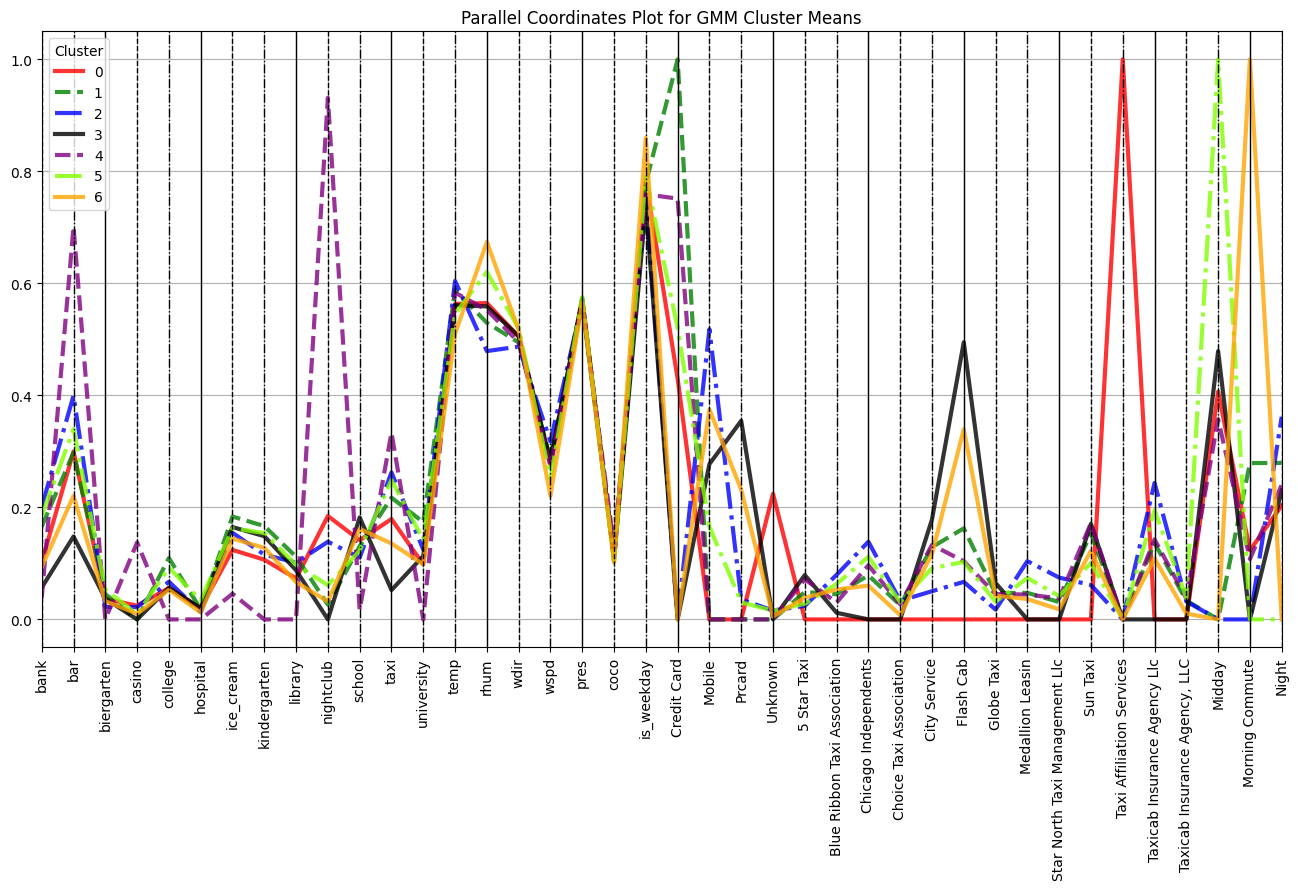

In [15]:
custom_colors = ['red', 'green', 'blue', 'black', 'purple', '#80FF00', 'orange']

number_of_clusters = scaled_gmm_cluster_means['GMM_Cluster'].nunique()
if number_of_clusters <= len(custom_colors):
    color_map = custom_colors[:number_of_clusters]
else:
    color_map = plt.get_cmap('tab10')


plt.figure(figsize=(16, 8))
parallel_coordinates(scaled_gmm_cluster_means, 'GMM_Cluster', color=color_map,linewidth=3,alpha=0.8)

ax = plt.gca()
line_styles = ['-', '--','-.']
lines = ax.get_lines()  
for i, line in enumerate(lines):
    line.set_linestyle(line_styles[i % len(line_styles)])
    
plt.title('Parallel Coordinates Plot for GMM Cluster Means')
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.savefig('parrallel_coordinate_gmm.png', bbox_inches='tight')    
plt.show()

Cluster 0: "Affiliated Daytime Service"
- High affiliation with Taxi Affiliation Services
- High usage of Credit Cards during midday hours
- Moderate morning commute activity
- Some nightlife presence

Cluster 1: "Exclusive Credit Card Users" 
- Exclusively uses credit cards
- Higher activity during morning commutes

Cluster 2: "Mobile Night Riders"
- Predominant activity during the night
- Frequent use of mobile payments
- Moderate nightlife presence

Cluster 3: "Daytime Non-Credit Users"
- Predominantly active during midday but does not prefer credit card usage
  
Cluster 4: "Nightlife Hotspot"
- Very high nightlife activity
- High use of credit cards
- Active during midday and some morning commute hours
  
Cluster 5: "Peak Daytime Activity"
- Highest activity during midday hours
- Significant use of credit cards
- Some nightlife activity
  
Cluster 6: "Morning Commuters"
- Highest activity during morning commutes
- Does not focus on credit card usage

### KMeans

In [16]:
scaled_df['KMean_Cluster'] = kmeans.labels_
scaled_df['KMean_Cluster'] = scaled_df['KMean_Cluster'].astype('category')
scaled_cluster_means = scaled_df.drop(['GMM_Cluster'],axis=1).groupby('KMean_Cluster').mean()
scaled_cluster_means.reset_index(inplace=True)

/var/folders/rv/2hmk4mb56wbcppq_hm6cxb5r0000gn/T/ipykernel_26490/3999301678.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scaled_cluster_means = scaled_df.drop(['GMM_Cluster'],axis=1).groupby('KMean_Cluster').mean()


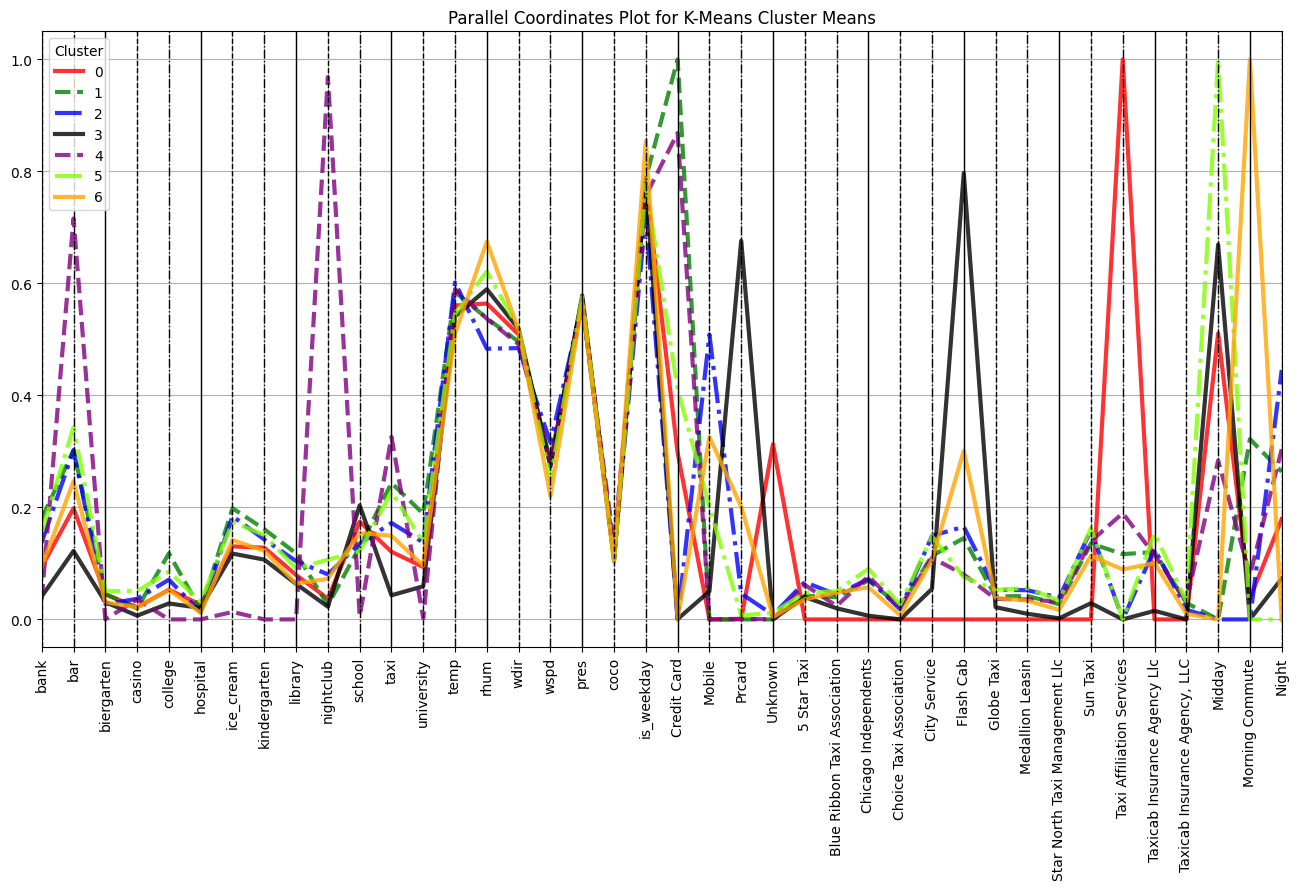

In [17]:
custom_colors = ['red', 'green', 'blue', 'black', 'purple', '#80FF00', 'orange']

number_of_clusters = scaled_cluster_means['KMean_Cluster'].nunique()
if number_of_clusters <= len(custom_colors):
    color_map = custom_colors[:number_of_clusters]
else:
    color_map = plt.get_cmap('tab10')


plt.figure(figsize=(16, 8))
parallel_coordinates(scaled_cluster_means, 'KMean_Cluster', color=color_map,linewidth=3, alpha=0.8)

ax = plt.gca()
line_styles = ['-', '--','-.']
lines = ax.get_lines()  
for i, line in enumerate(lines):
    line.set_linestyle(line_styles[i % len(line_styles)])
    
plt.title('Parallel Coordinates Plot for K-Means Cluster Means')
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.savefig('parrallel_coordinate_kmean.png',bbox_inches='tight')  
plt.show()

Similar clustering as GMM

## b. Feature importance

### KMeans

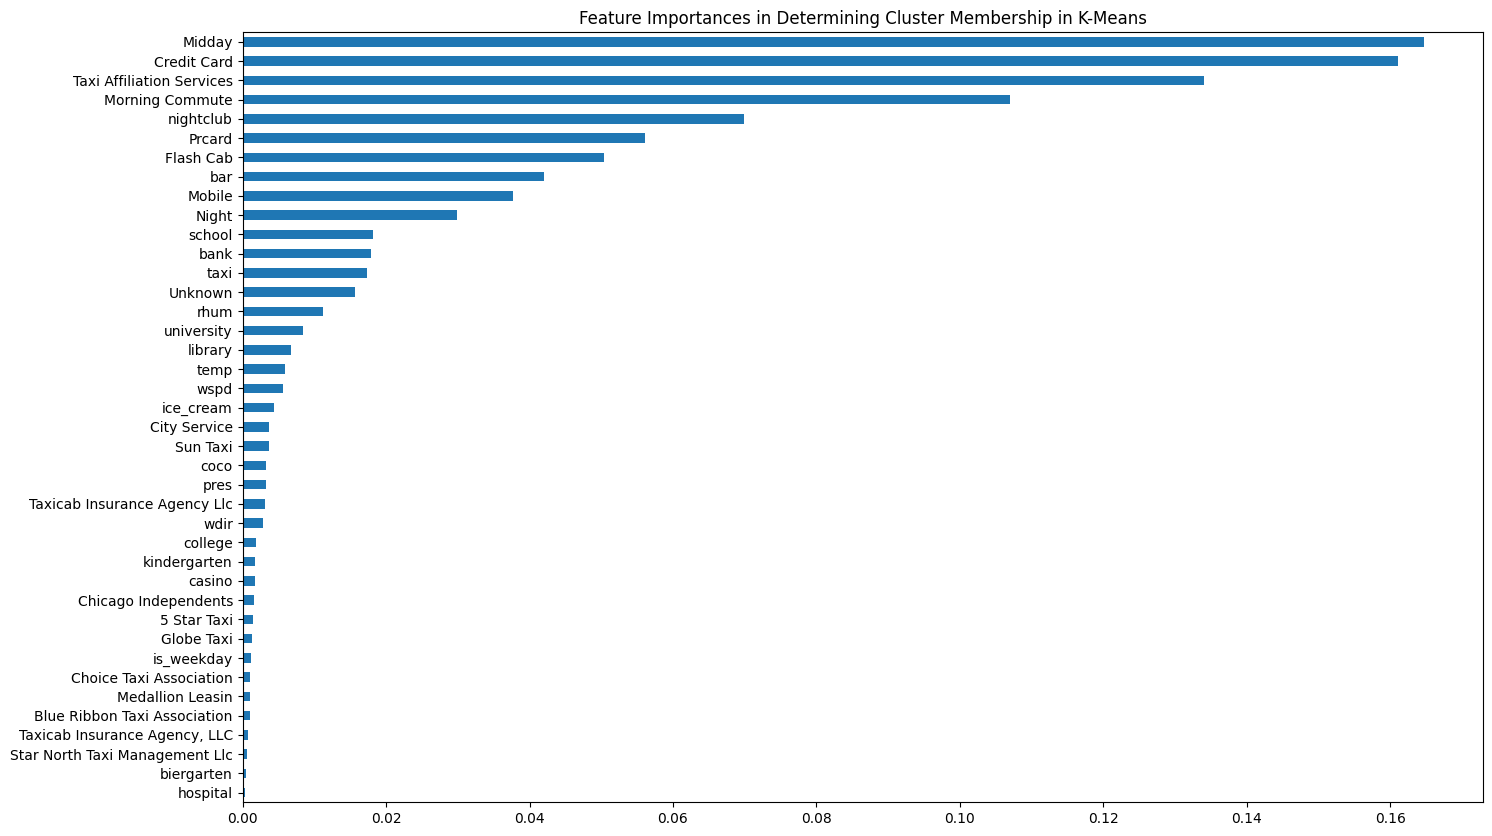

In [18]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(scaled_df.drop(['KMean_Cluster','GMM_Cluster'], axis=1), scaled_df['KMean_Cluster'])


importances_kmean = pd.Series(rf.feature_importances_, index=scaled_df.drop(['GMM_Cluster','KMean_Cluster'],axis=1).columns)
plt.figure(figsize=(16, 10))
importances_kmean.sort_values().plot(kind='barh')
plt.title('Feature Importances in Determining Cluster Membership in K-Means')
plt.savefig('ft_importance_kmean.png',bbox_inches='tight')  
plt.show()

### GMM

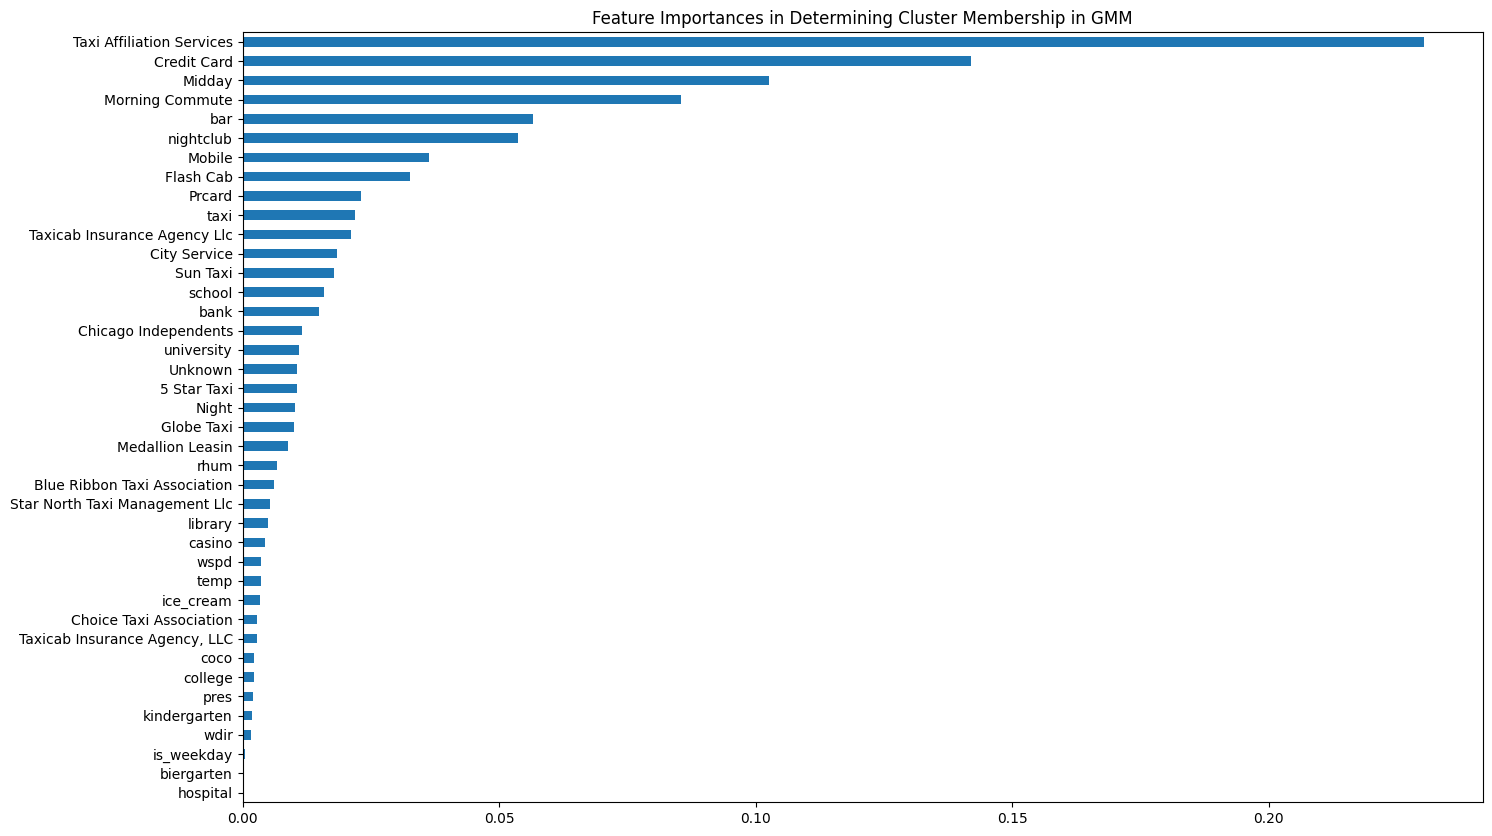

In [19]:
rf2 = RandomForestClassifier(n_estimators=100)
rf2.fit(scaled_df.drop(['GMM_Cluster','KMean_Cluster'], axis=1), scaled_df['GMM_Cluster'])

importances_gmm = pd.Series(rf2.feature_importances_, index=scaled_df.drop(['GMM_Cluster','KMean_Cluster'],axis=1).columns)
plt.figure(figsize=(16, 10))
importances_gmm.sort_values().plot(kind='barh')
plt.title('Feature Importances in Determining Cluster Membership in GMM')
plt.savefig('ft_importance_gmm.png',bbox_inches='tight')  
plt.show()

## c. Conclusion

In [20]:
scaled_cluster_means.to_csv('mean_diff_kmean.csv',index=False)
scaled_gmm_cluster_means.to_csv('mean_diff_gmm.csv',index=False)
importances_kmean.reset_index().to_csv('ft_importance_kmean.csv',index=False)
importances_gmm.reset_index().to_csv('ft_importance_gmm.csv',index=False)

Overlap in Labels: Despite some small differences in the values, both clustering methods (GMM and KMeans) provide the same clustering and also identify clusters focused on credit card usage, specific times of day (like midday and morning commutes), and nightlife activity.

Different feature importance: Despite resulting in same clustering, GMM and KMeans rank the importance of the features a bit differently. 
    

# 4. Hot Spot Identification

/var/folders/rv/2hmk4mb56wbcppq_hm6cxb5r0000gn/T/ipykernel_26490/3152594033.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


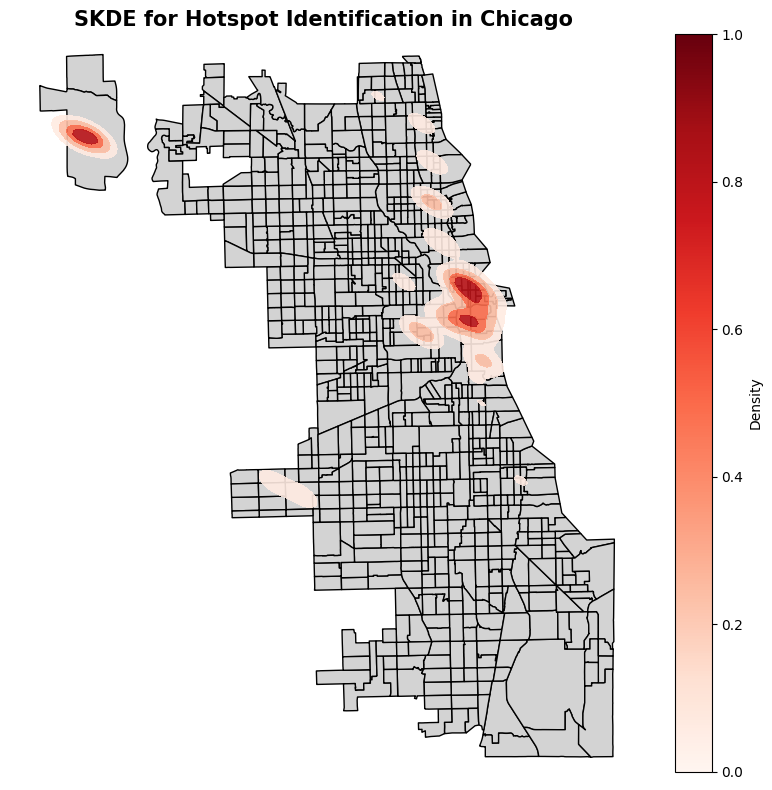

In [21]:
chicago_map = gpd.read_file('census_tract/geo_export_0caa4a0b-c5b9-4cef-b66d-72eced332409.shp')
df = pd.read_csv('clustering_data.csv')

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['Pickup Centroid Longitude'], df['Pickup Centroid Latitude']))
gdf = gdf.set_crs('EPSG:4326')  
gdf = gdf.to_crs(chicago_map.crs)  

f, ax = plt.subplots(ncols=1, figsize=(20, 8))

chicago_map.plot(ax=ax, color='lightgray', edgecolor='black') 

levels = [0.2, 0.4, 0.6, 0.8, 1]
cmap = sns.color_palette("Reds", as_cmap=True)

# KDE plot on the map
sns.kdeplot(
    ax=ax,
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    levels=levels,
    shade=True,
    cmap=cmap,
    alpha=0.9
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Density')

ax.set_title('SKDE for Hotspot Identification in Chicago', fontsize=15, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.savefig('SKDE_hotspots.png')  
plt.show()